In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/__results__.html
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/vectorizedData.csv
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/__notebook__.ipynb
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/__output__.json
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/custom.css
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/__results___files/__results___9_0.png


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load data
data_path = '/kaggle/input/2-recommended-reads-conversion-of-data-to-num/vectorizedData.csv'
data = pd.read_csv(data_path)
data = data.drop_duplicates(subset=['booktitle', 'authorname'], keep='first')
data["word2vec"] = data["word2vec"].apply(lambda x: x.strip('[]'))
data["word2vec"] = data["word2vec"].apply(lambda x: x.split())
data["word2vec"] = data["word2vec"].apply(lambda x:  [float(y) for y in x])
# Extract word2vec embeddings and target variable
X = np.array(data['word2vec'].tolist())
y = data['ratingscore']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the word2vec embeddings using standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

model_path = '/kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin'

# Google News Binary modelini yükleme
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Kullanıcının girdiği kitap betimlemesi
user_description = "A space adventure with friends."
user_vector = np.mean([word_vectors[word] for word in user_description.split() if word in word_vectors.key_to_index], axis=0)

# Use the model for prediction
new_word2vec = scaler.transform(user_vector.reshape(1, -1))
new_rating = model.predict(new_word2vec)
print(f'Predicted rating: {new_rating[0]:.2f}')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RMSE: 0.28
Predicted rating: 3.71


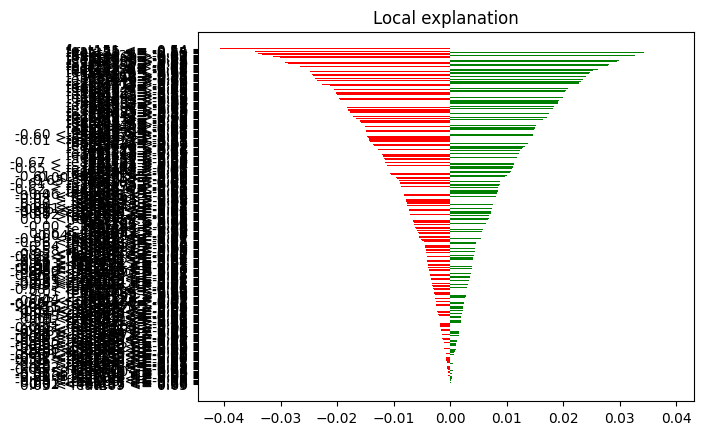

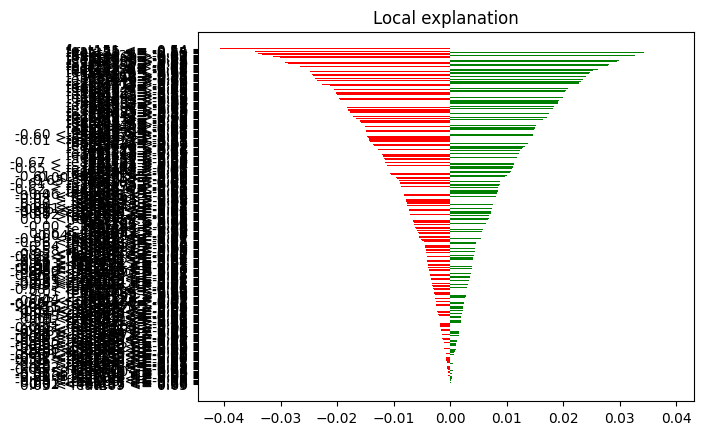

In [3]:
import lime
import lime.lime_tabular

# Define the explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=['feat'+str(i) for i in range(X_train.shape[1])],
    class_names=['ratingscore'],
    mode='regression'
)

# Choose a random test example
test_idx = 42

# Get the predicted rating for the test example
y_pred = model.predict(X_test[test_idx].reshape(1, -1))

# Get the LIME explanation for the predicted rating
exp = explainer.explain_instance(
    X_test[test_idx].ravel(),
    model.predict,
    num_features=X_train.shape[1]
)


# visualize the explanation
exp.as_pyplot_figure()